In [ ]:
pip install sklearn matplotlib

In [ ]:
pip install transformers

In [ ]:
import os
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE
from ast import literal_eval


# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModelForSequenceClassification.from_pretrained("bucketresearch/politicalBiasBERT")

In [ ]:
def get_model_prediction(text):
    tokenized_inputs = tokenizer(text, truncation=True, return_tensors='pt', max_length=512)
    inputs = {'input_ids': tokenized_inputs['input_ids'], 'attention_mask': tokenized_inputs['attention_mask']}
    outputs = model(**inputs)
    logits = outputs[0]
    probs = logits.softmax(dim=-1)[0].tolist()
    score = probs[0] * 1/6 + probs[1] * 3/6 + probs[2] * 5/6
    #stance_mapping = {0: "left", 1: "center", 2: "right"}
    #predicted_stance = stance_mapping[probs.index(max(probs))]

    # Get the embeddings from one of the last layers
    embeddings = outputs.hidden_states[-2][0].mean(dim=0)

    return embeddings, probs, score

In [ ]:
# Load the filtered speeches and metadata
file_path = 'filtered_metadata_with_party.csv'
df = pd.read_csv(file_path)

In [ ]:
df.isnull().sum()

speech_id     0
chamber       0
date          0
speaker       0
first_name    0
last_name     0
state         0
gender        0
char_count    0
word_count    0
party         0
speech        0
dtype: int64

In [ ]:
df.duplicated().sum()

0

In [ ]:
df['party'].value_counts()

D    5296
R    2707
I     160
P       1
Name: party, dtype: int64

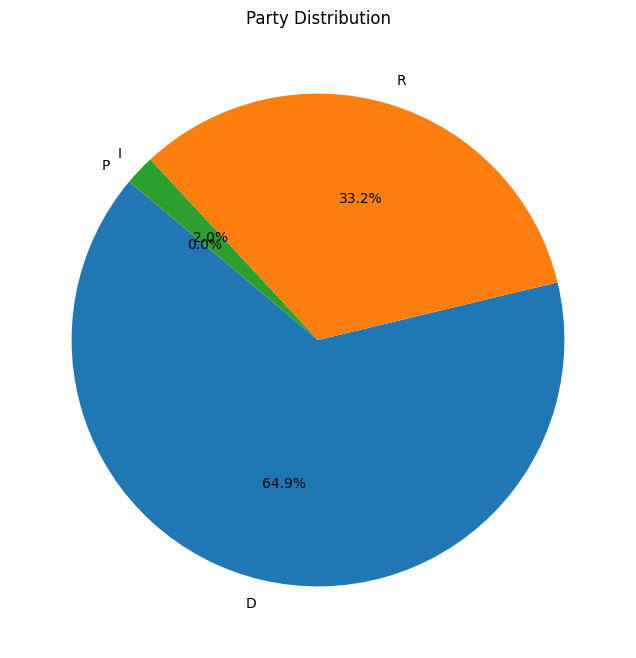

In [ ]:
# Count the frequency of each party
party_counts = df['party'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(party_counts, labels=party_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Party Distribution')
plt.show()

Removing parties "I" and "P"

In [ ]:
df = df[df['party'].isin(['D', 'R'])]

D    5296
R    2707
Name: party, dtype: int64


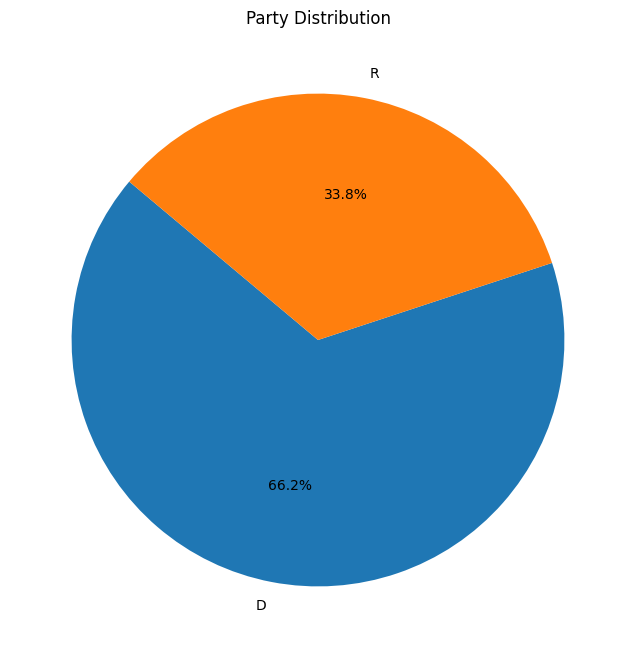

In [ ]:
# Count the frequency of each party
party_counts = df['party'].value_counts()
print(party_counts)

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(party_counts, labels=party_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Party Distribution')
plt.show()

In [ ]:
df_100 = df[0:100]

In [ ]:
true_labels = df['party'].tolist()
predicted_labels = []

In [ ]:
# Function to apply predictions
def apply_prediction(row):
    embeddings, probs, score = get_model_prediction(row['text'])
    row['embeddings'] = embeddings.detach().numpy()
    row['left_prob'] = probs[0]
    row['center_prob'] = probs[1]
    row['right_prob'] = probs[2]
    row['score'] = score
    row['predicted_stance'] = 'right' if score > 0.5 else 'left'
    return row

In [ ]:
df_test = df[0:5]

In [ ]:
model.config.output_hidden_states = True

In [ ]:
# Apply the function
tqdm.pandas(desc="Processing speeches")
df_processed = df.progress_apply(apply_prediction, axis=1)

# Write the updated DataFrame to a new CSV file
df_processed.to_csv('updated_dataset_new.csv', index=False)

Accuracy

In [ ]:
# Read the CSV file into a DataFrame
df = pd.read_csv('updated_dataset_new.csv')

In [ ]:

# Map party labels 'D' to 'left' and 'R' to 'right'
df['party_conv'] = df['party'].map({'D': 'left', 'R': 'right'})

# Calculate accuracy
correct_predictions = (df['party_conv'] == df['predicted_stance']).sum()
total_predictions = len(df)

accuracy = correct_predictions / total_predictions
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 36.65%


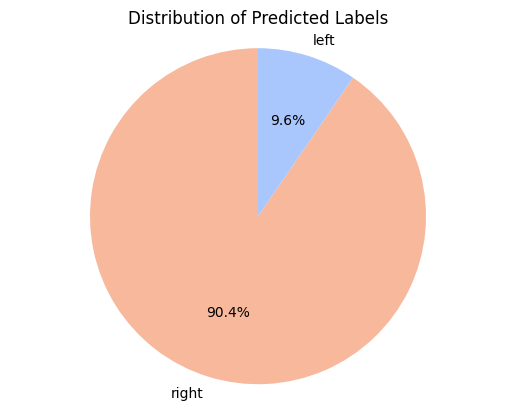

In [ ]:
# Calculate label counts from the "predicted_stance" column
label_counts = df['predicted_stance'].value_counts()

colors = sns.color_palette("coolwarm", len(label_counts))
colors = colors[::-1]

# Plot the pie chart
fig1, ax1 = plt.subplots()
ax1.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors = colors)
ax1.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.
plt.title("Distribution of Predicted Labels")
plt.show()

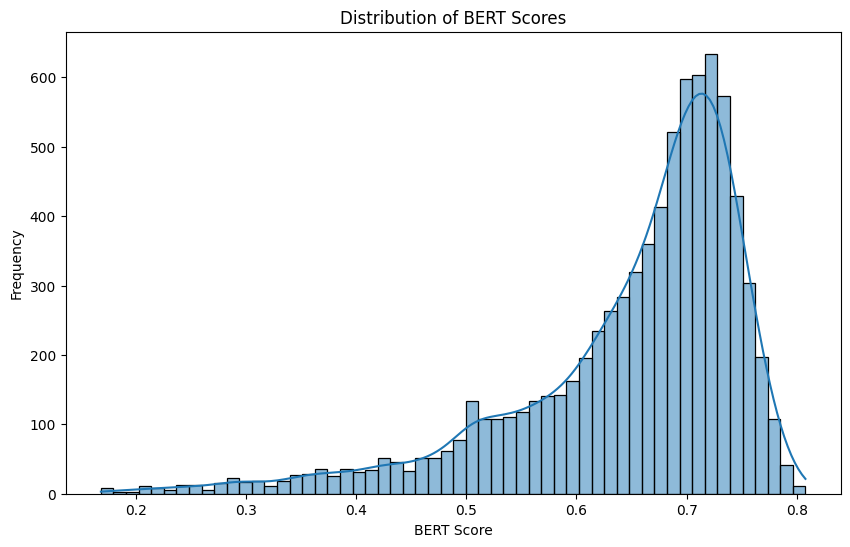

In [ ]:
# BERT Score Distribution Plot
plt.figure(figsize=(10, 6))
sns.histplot(df['score'], kde=True)
plt.title('Distribution of BERT Scores')
plt.xlabel('BERT Score')
plt.ylabel('Frequency')
plt.show()



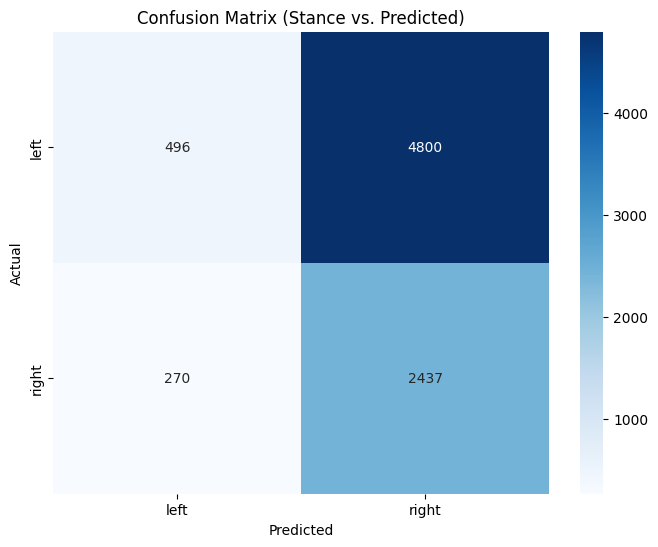

In [ ]:
# Create a confusion matrix
actual_labels = df['party_conv']
predicted_labels = df['predicted_stance']

unique_labels = np.unique(actual_labels)

conf_matrix = confusion_matrix(actual_labels, predicted_labels, labels=unique_labels)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Stance vs. Predicted)')
plt.show()

In [ ]:
#
df_test = df[0:10]

In [ ]:
# Function to convert string embeddings to numpy arrays
def convert_embedding(embedding_str):
    return np.array([float(num) for num in embedding_str.strip('[]').split()])

# Apply the function to convert embeddings
df_test['embeddings_test'] = df_test['embeddings'].apply(convert_embedding)
embeddings = np.vstack(df_test['embeddings_test'])

<ipython-input-94-fcf65c7da8d5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['embeddings_test'] = df_test['embeddings'].apply(convert_embedding)


In [ ]:
# Function to convert string embeddings to numpy arrays
def convert_embedding(embedding_str):
    return np.array([float(num) for num in embedding_str.strip('[]').split()])

# Apply the function to convert embeddings
df['embeddings_vis'] = df['embeddings'].apply(convert_embedding)
embeddings = np.vstack(df['embeddings_vis'])

In [ ]:
import time
from sklearn.manifold import TSNE
import numpy as np

# Assuming 'embeddings' is your full embeddings data
sample_embeddings = embeddings[:1000]  # Adjust the sample size as needed

# Time the t-SNE fit_transform on the sample
start_time = time.time()
tsne = TSNE(n_components=2, random_state=42)
sample_reduced = tsne.fit_transform(sample_embeddings)
end_time = time.time()

# Calculate and print the time taken
time_taken = end_time - start_time
print(f"Time taken for t-SNE on sample: {time_taken:.2f} seconds")

# You can use this to estimate the time for the full dataset
estimated_time_full = time_taken * (len(embeddings) / len(sample_embeddings))
print(f"Estimated time for full dataset: {estimated_time_full:.2f} seconds")

Time taken for t-SNE on sample: 8.51 seconds
Estimated time for full dataset: 68.10 seconds


In [ ]:
len(embeddings)

8003

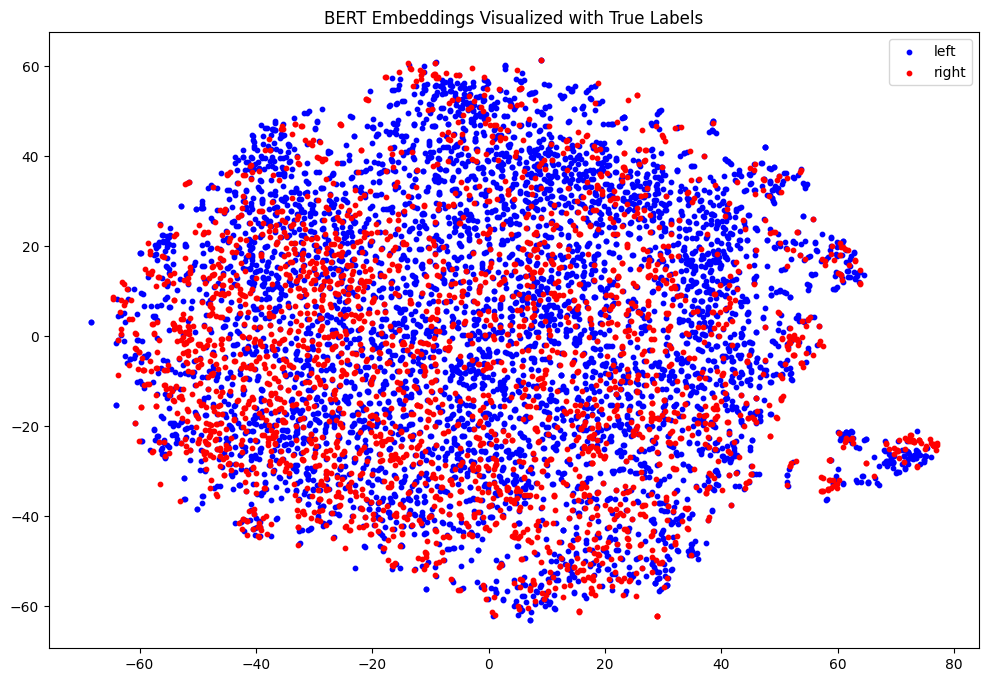

In [ ]:
import matplotlib.pyplot as plt

# Dimensionality Reduction
embeddings_reduced = TSNE(n_components=2, random_state=42).fit_transform(embeddings)

# Plotting
plt.figure(figsize=(12, 8))  # Make the plot larger
unique_labels = set(df['party_conv'])
for label in unique_labels:
    indices = [i for i, x in enumerate(df['party_conv']) if x == label]
    color = 'red' if label == 'right' else 'blue' if label == 'left' else 'green'
    plt.scatter(embeddings_reduced[indices, 0], embeddings_reduced[indices, 1],
                c=color, label=label, s=10)  # Adjust alpha and size

plt.legend()
plt.title("BERT Embeddings Visualized with True Labels")
plt.show()

In [ ]:
import time
from sklearn.manifold import TSNE
import numpy as np

# Assuming 'embeddings' is your full embeddings data
sample_embeddings = embeddings[:100]  # Adjust the sample size as needed

# Time the t-SNE fit_transform on the sample
start_time = time.time()
tsne = TSNE(n_components=2, random_state=42)
sample_reduced = tsne.fit_transform(sample_embeddings)
end_time = time.time()

# Calculate and print the time taken
time_taken = end_time - start_time
print(f"Time taken for t-SNE on sample: {time_taken:.2f} seconds")

# You can use this to estimate the time for the full dataset
estimated_time_full = time_taken * (len(embeddings) / len(sample_embeddings))
print(f"Estimated time for full dataset: {estimated_time_full:.2f} seconds")

Time taken for t-SNE on sample: 0.81 seconds
Estimated time for full dataset: 64.90 seconds


# Threshold

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

# Load file
df = pd.read_csv('updated_dataset_new.csv')

# Map 'party' column to 'left' and 'right'
df['actual_stance'] = df['party'].map({'D': 'left', 'R': 'right'})

# Calculate actual distribution
actual_distribution = df['actual_stance'].value_counts(normalize=True)

# possible threshold values
thresholds = np.linspace(0, 1, 101)

best_threshold = 0
min_distribution_diff = float('inf')
best_accuracy = 0

# Iterating over thresholds
for threshold in thresholds:
    df['predicted_stance'] = df['score'].apply(lambda x: 'right' if x > threshold else 'left')

    # Calculating distribution difference
    predicted_distribution = df['predicted_stance'].value_counts(normalize=True)
    distribution_diff = np.abs(predicted_distribution - actual_distribution).sum()

    # Calculating accuracy
    accuracy = accuracy_score(df['actual_stance'], df['predicted_stance'])

    if distribution_diff < min_distribution_diff:
        min_distribution_diff = distribution_diff
        best_threshold = threshold
        best_accuracy = accuracy

print(f"Best Threshold: {best_threshold}")
print(f"Minimum Distribution Difference: {min_distribution_diff}")
print(f"Accuracy at Best Threshold: {best_accuracy}")

Best Threshold: 0.71
Minimum Distribution Difference: 0.01724353367487197
Accuracy at Best Threshold: 0.5717855804073473


**without threshold**

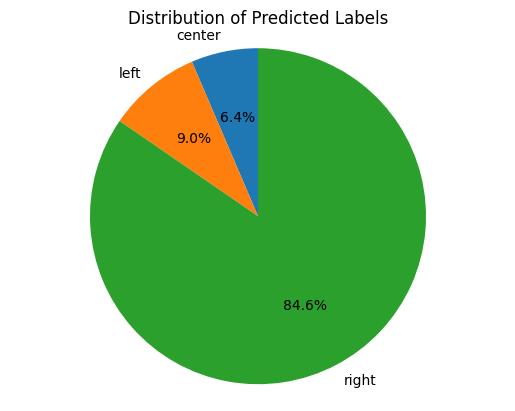

In [ ]:
# Create a pie chart for predicted labels
label_counts = {label: predicted_labels.count(label) for label in set(predicted_labels)}
labels = label_counts.keys()
sizes = label_counts.values()

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Distribution of Predicted Labels")
plt.show()

In [ ]:
# Transformation dictionary
transformation = {"D": "left", "R": "right"}

Accuracy: 0.3698
              precision    recall  f1-score   support

        left       0.64      0.09      0.16      4925
       right       0.34      0.90      0.49      2563

    accuracy                           0.37      7488
   macro avg       0.49      0.50      0.33      7488
weighted avg       0.54      0.37      0.28      7488



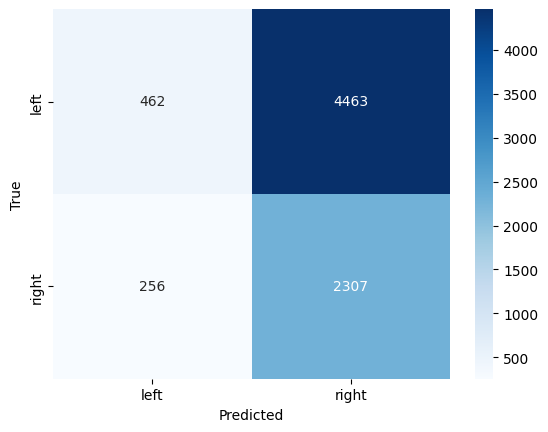

In [ ]:
import seaborn as sns
# Transform the true labels
transformed_true_labels = [transformation.get(label) for label in true_labels]

# Filter out 'center' predictions for direct comparison
filtered_indices = [i for i, label in enumerate(predicted_labels) if label != 'center']
filtered_true_labels = [transformed_true_labels[i] for i in filtered_indices]
filtered_predicted_labels = [predicted_labels[i] for i in filtered_indices]

# Accuracy and Classification Report
accuracy = accuracy_score(filtered_true_labels, filtered_predicted_labels)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(filtered_true_labels, filtered_predicted_labels))

# Confusion Matrix
cm = confusion_matrix(filtered_true_labels, filtered_predicted_labels, labels=["left", "right"])
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=["left", "right"], yticklabels=["left", "right"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()